In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [ ]:
DATA_PATH = "/kaggle/input/fyp-dataset/AffectNet/"
TOP_EMOTIONS = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

TRAIN_SIZE = 0.80
INPUT_SHAPE = (128,128,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [ ]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

surprise has 1851 number of images
fear has 1839 number of images
neutral has 1880 number of images
sad has 1821 number of images
disgust has 1740 number of images
contempt has 1833 number of images
happy has 1862 number of images
anger has 1822 number of images

total images are 14648


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))  # Resize the image to 128x128
            img_arr.append(np.expand_dims(img, axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

img_arr.shape, img_label.shape, label_to_text

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded contempt images to numpy arrays...
loaded happy images to numpy arrays...
loaded anger images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((14648, 128, 128, 1),
 (14648, 8),
 {0: 'surprise',
  1: 'fear',
  2: 'neutral',
  3: 'sad',
  4: 'disgust',
  5: 'contempt',
  6: 'happy',
  7: 'anger'})

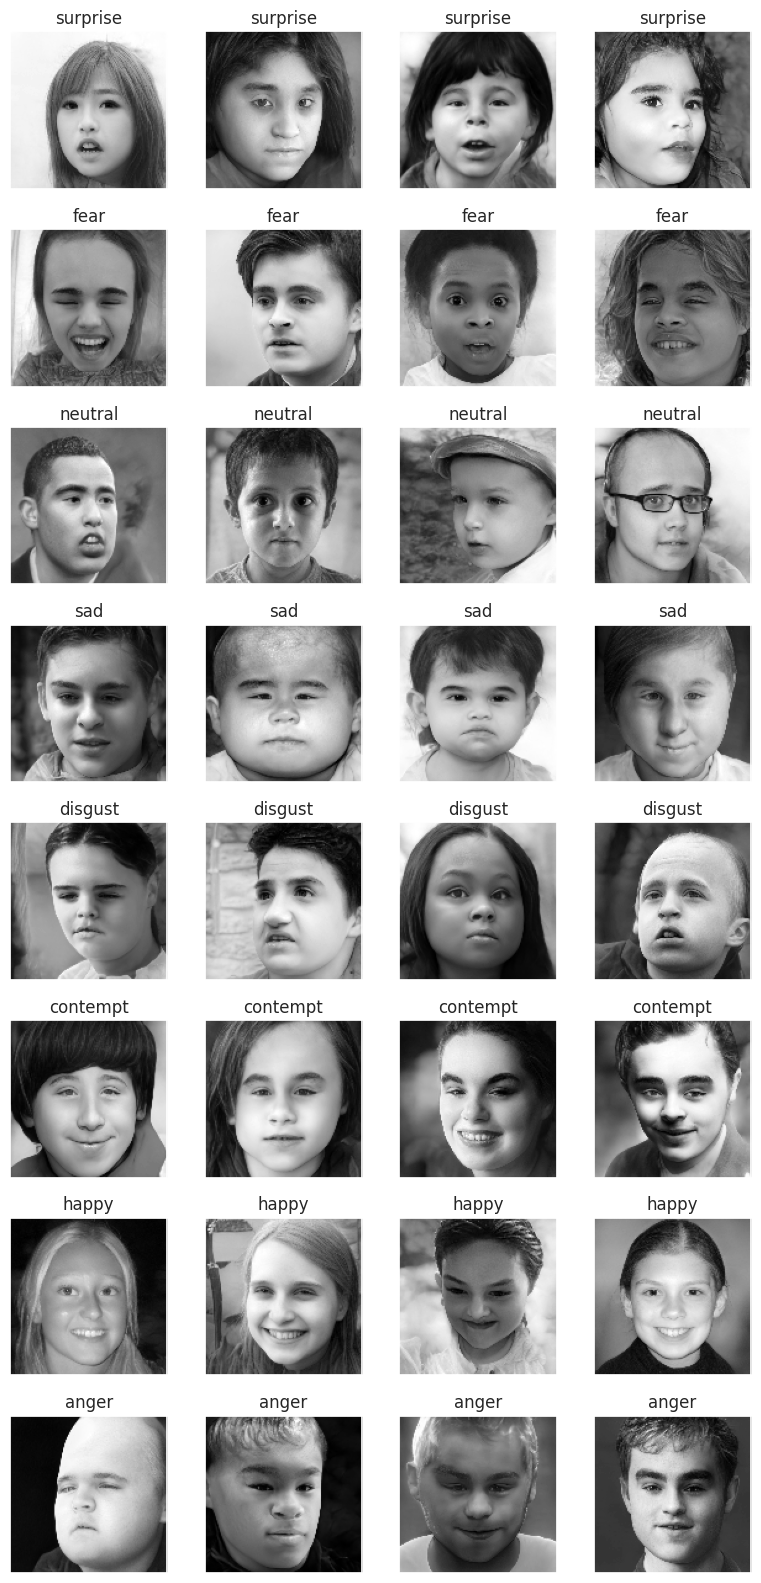

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(128, 128), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11718, 128, 128, 1), (2930, 128, 128, 1), (11718, 8), (2930, 8))

In [ ]:
# Model architecture - XceptionNet
def xception_block_1(X, filters: int, block_id: int, pre_activation=True):
    X_shortcut = X

    actv_id = 1
    if pre_activation:
        X = Activation("relu", name=f"xb1_block{block_id}_actv{actv_id}")(X)
        actv_id += 1

    X = SeparableConv2D(
        filters=filters,
        kernel_size=(3, 3),
        padding="same",
        use_bias=False,
        depthwise_initializer=he_normal(seed=42),
        pointwise_initializer=he_normal(seed=42),
        name=f"xb1_block{block_id}_sepconv1",
    )(X)
    X = BatchNormalization(name=f"xb1_block{block_id}_bn1")(X)
    X = Activation("relu", name=f"xb1_block{block_id}_actv{actv_id}")(X)

    X = SeparableConv2D(
        filters=filters,
        kernel_size=(3, 3),
        padding="same",
        use_bias=False,
        depthwise_initializer=he_normal(seed=42),
        pointwise_initializer=he_normal(seed=42),
        name=f"xb1_block{block_id}_sepconv2",
    )(X)
    X = BatchNormalization(name=f"xb1_block{block_id}_bn2")(X)

    X = MaxPooling2D(
        pool_size=(3, 3),
        strides=(2, 2),
        padding="same",
        name=f"xb1_block{block_id}_maxpool",
    )(X)

    X_residual = Conv2D(
        filters=filters,
        kernel_size=(1, 1),
        strides=(2, 2),
        padding="same",
        use_bias=False,
        kernel_initializer=he_normal(seed=42),
        name=f"xb1_block{block_id}_resconv"
    )(X_shortcut)
    X_residual = BatchNormalization(name=f"xb1_block{block_id}_resbn")(X_residual)

    return Add()([X, X_residual])

In [ ]:
def xception_block_2(X, block_id: int):
    X_shortcut = X

    for i in range(2):
        X = Activation("relu", name=f"xb2_block{block_id}_actv{i+1}")(X)
        X = SeparableConv2D(
            filters=512,
            kernel_size=(3,3),
            padding="same",
            use_bias=False,
            depthwise_initializer=he_normal(seed=42),
            pointwise_initializer=he_normal(seed=42),
            name=f"xb2_block{block_id}_sepconv{i+1}",
        )(X)
        X = BatchNormalization(name=f"xb2_block{block_id}_bn{i+1}")(X)

    return Add()([X, X_shortcut])

In [ ]:
def XceptionNet(in_shape, out_shape, show_summary=False):
    "Shallow implementation of Xception net"

    model_in = Input(shape=in_shape, name="in_layer")

    X = Conv2D(
        filters=64,
        kernel_size=(3,3),
        strides=(1,1),
        use_bias=False,
        kernel_initializer=he_normal(seed=42),
        name="conv1"
    )(model_in)
    X = BatchNormalization(name="bn1")(X)
    X = Activation("relu", name="actv1")(X)
    X = Conv2D(
        filters=128,
        kernel_size=(3,3),
        strides=(1,1),
        use_bias=False,
        kernel_initializer=he_normal(seed=42),
        name="conv2"
    )(X)
    X = BatchNormalization(name="bn2")(X)
    X = Activation("relu", name="actv2")(X)

    X = xception_block_1(X, filters=256, block_id=1, pre_activation=False)
    X = xception_block_1(X, filters=512, block_id=2,)

    for i in range(3):
        X = xception_block_2(X, block_id=i+1)

    X = xception_block_1(X, filters=728, block_id=3,)

    X = SeparableConv2D(
        filters=1024,
        kernel_size=(3,3),
        padding="same",
        use_bias=False,
        depthwise_initializer=he_normal(seed=42),  # Use depthwise_initializer
        pointwise_initializer=he_normal(seed=42),  # Use pointwise_initializer
        name="sepconv",
    )(X)

    X = BatchNormalization(name="bn3",)(X)
    X = Activation("relu", name="actv3",)(X)

    X = GlobalAveragePooling2D()(X)

    X = Dense(units=128, kernel_initializer=he_normal(seed=42), name="dense1")(X)
    X = BatchNormalization(name="bn4")(X)
    X = Activation("relu", name="actv4")(X)

    model_out = Dense(units=out_shape, activation="softmax", name="out_layer")(X)

    model = Model(model_in, model_out, name="XceptionNet")

    if show_summary:
        model.summary()

    return model

Model: "XceptionNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_layer            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 126, 126,  │        576 │ in_layer[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 126, 126,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actv1 (Activation)  │ (None, 126, 126,  │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 124, 124,  │     73,728 │ actv1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 124, 124,  │        512 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actv2 (Activation)  │ (None, 124, 124,  │          0 │ bn2[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_sepconv1 │ (None, 124, 124,  │     33,920 │ actv2[0][0]       │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_bn1      │ (None, 124, 124,  │      1,024 │ xb1_block1_sepco… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_actv1    │ (None, 124, 124,  │          0 │ xb1_block1_bn1[0… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_sepconv2 │ (None, 124, 124,  │     67,840 │ xb1_block1_actv1… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_bn2      │ (None, 124, 124,  │      1,024 │ xb1_block1_sepco… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_resconv  │ (None, 62, 62,    │     32,768 │ actv2[0][0]       │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_maxpool  │ (None, 62, 62,    │          0 │ xb1_block1_bn2[0… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block1_resbn    │ (None, 62, 62,    │      1,024 │ xb1_block1_resco… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 62, 62,    │          0 │ xb1_block1_maxpo… │
│                     │ 256)              │            │ xb1_block1_resbn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xb1_block2_actv1    │ (None, 62, 62,    │          0 │ add_6[0][0]     

 Total params: 4,547,032 (17.35 MB)

 Trainable params: 4,529,224 (17.28 MB)

 Non-trainable params: 17,808 (69.56 KB)

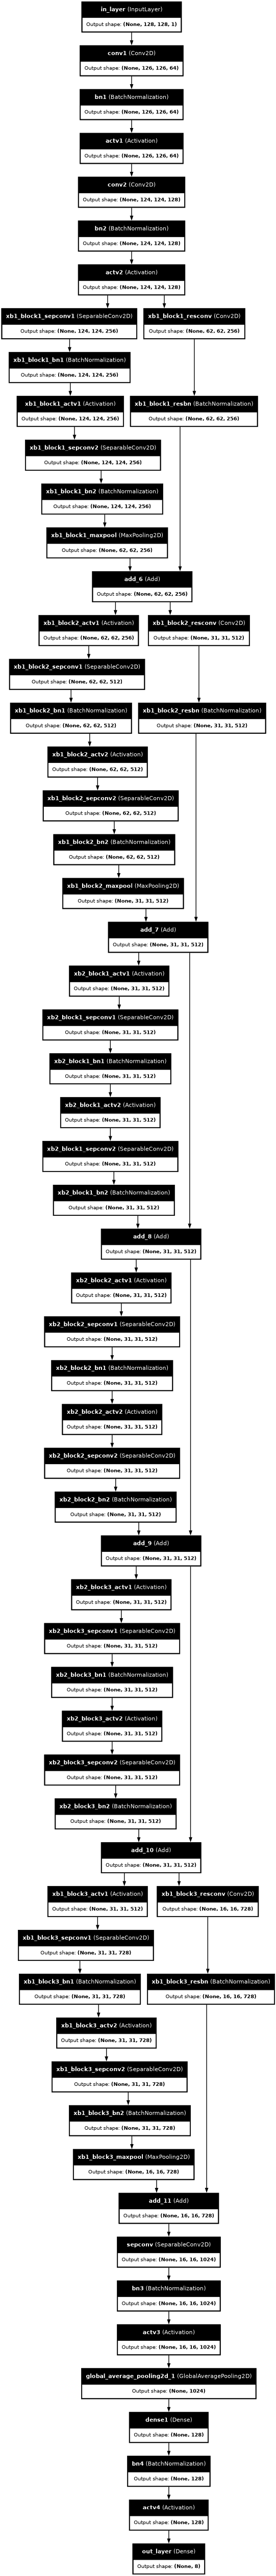

In [ ]:
model = XceptionNet(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [ ]:
def step_lr_scheduler(lr_max, lr_min, step_size, num_stairs, steps_per_stair):
    lr_list = []
    lr = lr_max

    for _ in range(num_stairs):
        for _ in range(steps_per_stair):
            lr_list.append(lr)
        if lr < lr_min:
            lr = lr_min
        else:
            lr *= step_size

    print("lr_list: ", lr_list)

    def lr_scheduler(epoch):
        return lr_list[epoch]

    return lr_scheduler


def cyclic_lr_scheduler(lr_max, lr_min, lr_max_decay, step_size, steps_per_cycle, num_cycles):
    lr_list = []
    lr = lr_max

    for _ in range(num_cycles):
        lr = (
            lr_min
            if lr < lr_min else
            lr_max
        )

        for _ in range(steps_per_cycle):
            lr_list.append(lr)
            lr *= step_size
            if lr < lr_min:
                lr = lr_min

        lr_max *= lr_max_decay

    print("lr_list: ", lr_list)

    def lr_scheduler(epoch):
        return lr_list[epoch]

    return lr_scheduler

lr_list:  [0.001, 0.001, 0.001, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 4e-05, 4e-05, 4e-05, 4e-05, 8.000000000000001e-06, 8.000000000000001e-06, 8.000000000000001e-06, 8.000000000000001e-06]


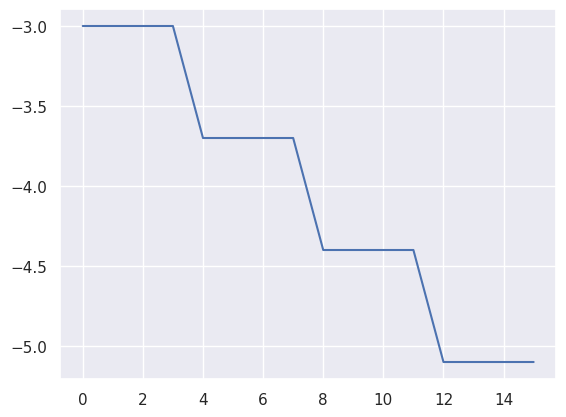

In [ ]:
epochs = 16
lr_scheduler = step_lr_scheduler(lr_max=1e-3, lr_min=1e-7, step_size=0.2, num_stairs=4, steps_per_stair=4)

# Visualizing the learning rate schedule
lrs = []
for e in range(epochs):
    lrs.append(lr_scheduler(e))

plt.plot(range(epochs), np.log10(lrs))
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

batch_size = 32
epochs = 16

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(0.01),
    metrics=['accuracy'],
)

history_XceptionNet = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = int(len(X_train) / batch_size),
    epochs = epochs,
    callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
)

Epoch 1/16


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 14:46:52.726152: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,256,124,124]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,124,124]{3,2,1,0}, f32[256,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=256, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-20 14:46:52.916643: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.190566783s
Trying algorithm 

184/366 ━━━━━━━━━━━━━━━━━━━━ 2:30 826ms/step - accuracy: 0.1577 - loss: 2.2050

W0000 00:00:1710946250.999993     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.1723 - loss: 2.1285

W0000 00:00:1710946377.783396     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 426s 864ms/step - accuracy: 0.1724 - loss: 2.1281 - val_accuracy: 0.1505 - val_loss: 2.1751 - learning_rate: 0.0010
Epoch 2/16


W0000 00:00:1710946415.135130     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/366 ━━━━━━━━━━━━━━━━━━━━ 3:57 651ms/step - accuracy: 0.3438 - loss: 1.7070

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.3438 - loss: 1.7070 - val_accuracy: 0.1522 - val_loss: 2.1815 - learning_rate: 0.0010
Epoch 3/16
366/366 ━━━━━━━━━━━━━━━━━━━━ 267s 729ms/step - accuracy: 0.2967 - loss: 1.7666 - val_accuracy: 0.2468 - val_loss: 2.5900 - learning_rate: 0.0010
Epoch 4/16
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.3438 - loss: 1.4796 - val_accuracy: 0.2495 - val_loss: 2.6889 - learning_rate: 0.0010
Epoch 5/16
366/366 ━━━━━━━━━━━━━━━━━━━━ 269s 733ms/step - accuracy: 0.4165 - loss: 1.4981 - val_accuracy: 0.4119 - val_loss: 1.4999 - learning_rate: 2.0000e-04
Epoch 6/16
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.4375 - loss: 1.2737 - val_accuracy: 0.4126 - val_loss: 1.4960 - learning_rate: 2.0000e-04
Epoch 7/16
366/366 ━━━━━━━━━━━━━━━━━━━━ 304s 733ms/step - accuracy: 0.4632 - loss: 1.3796 - val_accuracy: 0.4307 - val_loss: 1.4508 - learning_rate: 2.0000e-04
Epoch 8/16
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.5

In [ ]:
history = pd.DataFrame(history_XceptionNet.history)
history

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.202636,2.001762,0.150512,2.175121,0.001000
1,0.343750,1.707011,0.152218,2.181503,0.001000
2,0.321496,1.722723,0.246758,2.590031,0.001000
3,0.343750,1.479580,0.249488,2.688892,0.001000
4,0.429659,1.468409,0.411945,1.499901,0.000200
5,0.437500,1.273724,0.412628,1.496039,0.000200
6,0.465172,1.380833,0.430717,1.450818,0.000200
7,0.531250,1.213614,0.439932,1.439960,0.000200
8,0.507873,1.283895,0.497611,1.309766,0.000040
9,0.531250,1.001545,0.497952,1.307449,0.000040


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

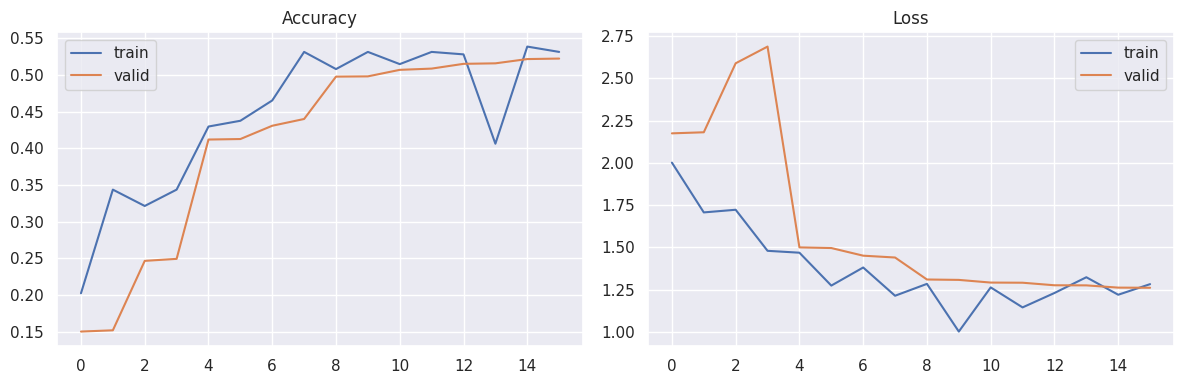

In [ ]:
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['accuracy'], label='train')
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['loss'], label='train')
sns.lineplot(x=history_XceptionNet.epoch, y=history_XceptionNet.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

367/367 - 68s - 185ms/step - accuracy: 0.5434 - loss: 1.1879


W0000 00:00:1710948541.507182     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.5434374213218689
92/92 - 17s - 182ms/step - accuracy: 0.5222 - loss: 1.2608

Test Accuracy: 0.5221843123435974
 2/92 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step

W0000 00:00:1710948562.009149     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step


W0000 00:00:1710948580.141224     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Classification Report:
               precision    recall  f1-score   support

       anger       0.44      0.41      0.42       370
    contempt       0.40      0.41      0.40       368
     disgust       0.70      0.87      0.78       376
        fear       0.39      0.29      0.33       364
       happy       0.46      0.29      0.35       348
     neutral       0.47      0.63      0.54       367
         sad       0.83      0.87      0.85       373
    surprise       0.37      0.39      0.38       364

    accuracy                           0.52      2930
   macro avg       0.51      0.52      0.51      2930
weighted avg       0.51      0.52      0.51      2930



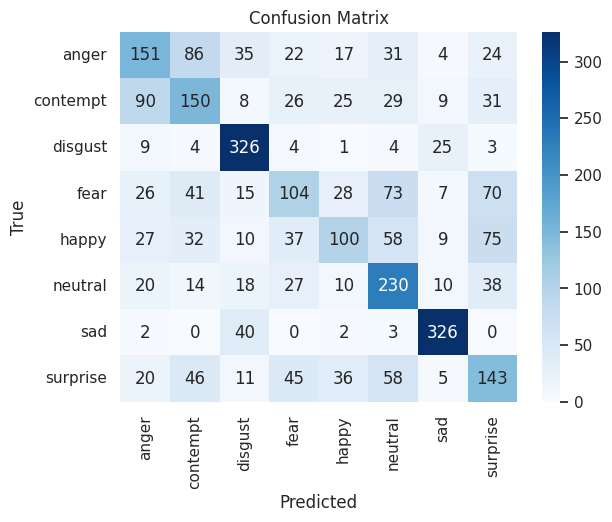

In [ ]:
from sklearn.metrics import confusion_matrix

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

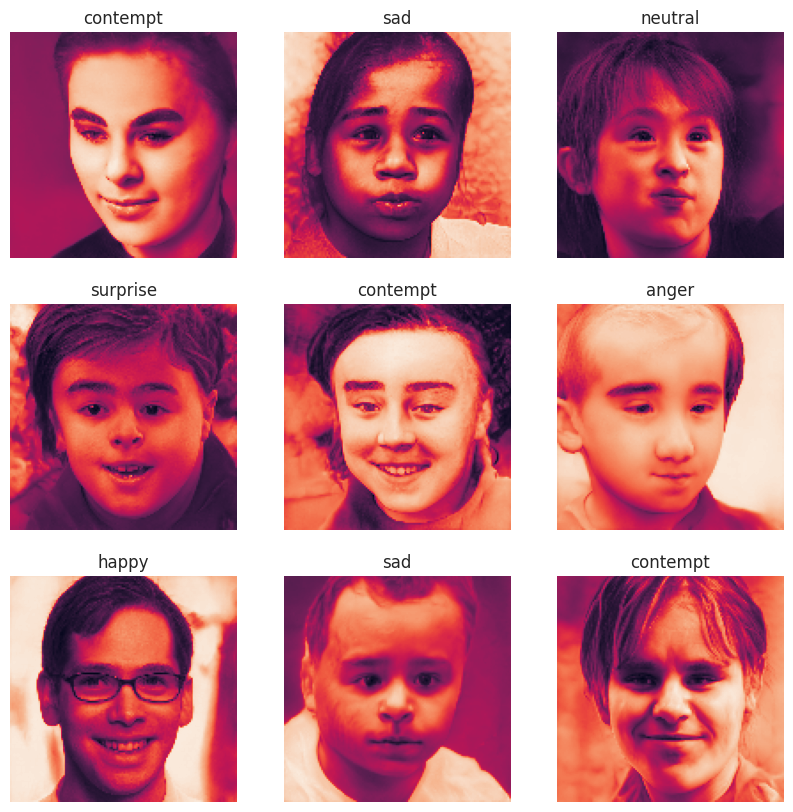

In [ ]:
# Visualize some predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title(label_to_text[predicted_labels[i]])
    plt.axis("off")

plt.show()